In [5]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

NameError: name 'p3' is not defined

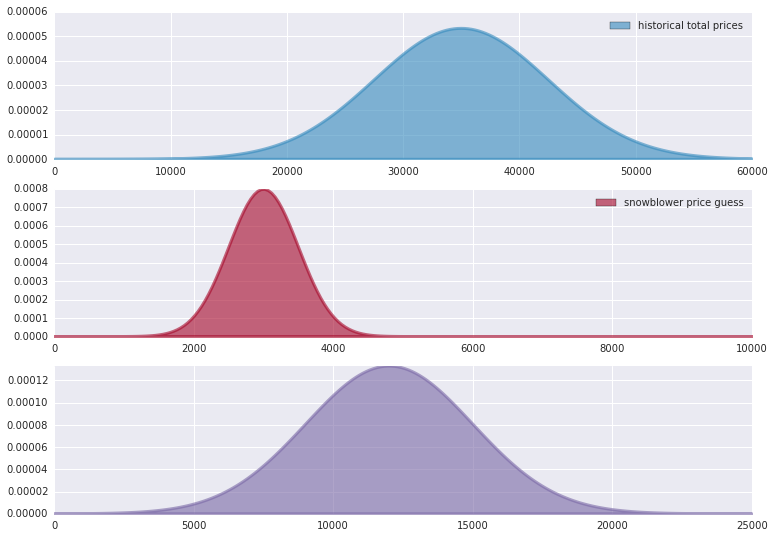

In [10]:
figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                      color="#348ABD", lw=3, alpha=0.6,
                      label="historical total prices")
p1 = plt.Rectangle((0,0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                      color="#A60628", lw=3, alpha=0.6,
                      label="snowblower price guess")

p2 = plt.Rectangle((0,0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                      color="#7A68A6", lw=3, alpha=0.6,
                      label="Trip price guess")
plt.autoscale(tight=True)
p2 = plt.Rectangle((0,0), 1, 1,fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])